# Warmte en welzijn: De relatie tussen klimaatsfactoren, socio-economische factoren en geluk
Student names: Reyna Geluk (15708845),
Lucas Vaneman (14663937),
Aryan Müller (15631591),
Mieke Fraters (15778770)   

Team number: C3 (#9)

In [1]:
# Alle imports
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

ModuleNotFoundError: No module named 'pandas'

![happyboy](images/happyboy.jpg)

# Introductie

## Onderwerp

Het geluksniveau van mensen wordt beïnvloed door een combinatie van vele factoren. In deze data-analyse onderzoeken we of en hoe weersomstandigheden en klimaatfactoren samenhangen met het gemiddelde geluk van mensen in verschillende landen. 

Klimaatfactoren kunnen de leefbaarheid van een land beïnvloeden (Peng et al., 2016; Rehdanz & Maddison, 2004; Tsutsui, 2013). Zo kan extreem weer, zoals langdurige kou, hittegolven of hoge neerslag, mogelijk leiden tot meer stress, gezondheidsproblemen of economische schade (Tsutsui, 2013; Rehdanz & Maddison, 2004). Anderzijds zijn er ook landen met minder aangename klimaten waar het geluksniveau toch hoog blijft, vaak dankzij sterke sociale vangnetten en economische stabiliteit.

Naast klimatologische factoren spelen ook sociale vangnetten en instituties een belangrijke rol in het verklaren van het geluksniveau in een land. Landen met goed ontwikkelde sociale structuren bieden vaak meer inkomenszekerheid, toegankelijke gezondheidszorg, goed onderwijs en sterke sociale cohesie. Deze factoren helpen burgers om beter om te gaan met tegenslagen, werkloosheid, ziekte of ouderdom, waardoor het algehele welzijn hoger blijft, zelfs bij ongunstige klimaatomstandigheden.

Het World Happiness Report benadrukt dat aspecten zoals sociale steun, vrijheid van keuzes, lage corruptieniveaus en sterke instituties sterk bijdragen aan het gemiddelde geluk in landen (Helliwell et al., 2017). Hierdoor kunnen landen met een relatief streng klimaat, zoals Scandinavië, toch hoog scoren op de wereldwijde gelukslijsten.

In deze studie proberen we inzicht te krijgen in de relatie tussen klimaat, sociaal-economische factoren en geluk. We baseren ons hierbij onder andere op eerder wetenschappelijk onderzoek dat suggereert dat zowel omgevingsfactoren als maatschappelijke structuren een rol spelen bij het ervaren van geluk.

### Weersomstandigheden en klimaatfactoren die we onderzoeken:
- Gemiddelde temperatuur
- Zonuren 
- Luchtkwaliteit
- Hoeveelheid natural disasters
- Bewolktheid


### Sociaal-economische factoren die we onderzoeken:
- GDP per capita
- Sociale steun
- Vrijheid
- Corruptieperceptie
- Gezondheidszorg

## Perspectieven en argumenten

### Perspectief 1: Klimaat heeft een sterke invloed op geluk
- **Argument 1.1**: In landen met een stabiel, mild of zonnig klimaat zijn mensen gemiddeld blijer, omdat dergelijke omstandigheden bijdragen aan een prettigere leefomgeving.
- **Argument 1.2**: Extreme weersomstandigheden zorgen voor stress en gezondheidsproblemen, wat het geluksniveau verlaagt.

### Perspectief 2: Sociaal-economische factoren zijn bepalender voor geluk dan klimaat
- **Argument 2.1**: Landen als Zweden, Noorwegen en Finland hebben lange, koude winters, maar behoren tot de gelukkigste landen dankzij sterke sociale vangnetten, gezondheidszorg en welvaart.
- **Argument 2.2**: Economische stabiliteit, werkgelegenheid, gezondheidszorg en sociale verbondenheid dragen meer bij aan geluk dan klimaatfactoren.

Met behulp van de beschikbare datasets proberen we deze perspectieven te toetsen aan de hand van concrete data en visualisaties.

# Dataset and Preprocessing

In [112]:
# Alle imports
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
import numpy as np
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Datasets importen
df1 = pd.read_csv('World-happiness-report-2024.csv')
df2 = pd.read_csv('GlobalWeatherRepository.csv')     # Main weather dataset, https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository
df3 = pd.read_csv('update_temperature.csv')          # Deze bevat ook de variabele voor natuurrampen, https://www.kaggle.com/datasets/adilshamim8/temperature

df2['last_updated'] = pd.to_datetime(df2['last_updated'])
df22024 = df2[df2['last_updated'].dt.year == 2024]  # Zo is de tabel gefilterd op values uit 2024

def mode(series):
    return series.mode().iloc[0] if not series.mode().empty else np.nan   # Vanwege een error met de mode krijgen van series
    
df2w = df22024.groupby('country').agg({
    'location_name': mode,
    'temperature_celsius' : 'mean',
    'feels_like_celsius' : 'mean',
    'cloud': 'mean',
    'wind_kph' : 'mean',
    'sunrise': mode,                      # dit gaan we ook nog veranderen naar een column voor de hoeveelheid uren daglicht. Kijk dus niet naar 
    'sunset' : mode,                      # deze column maar naar de Sunlight hours column. Kan zijn dat r misschien problemen komen met negatieve waarden btw.
    'air_quality_Carbon_Monoxide' : 'mean',
    'air_quality_Ozone' : 'mean',
    'air_quality_Nitrogen_dioxide' : 'mean',
    'air_quality_Sulphur_dioxide' : 'mean',
    'air_quality_PM2.5' : 'mean',
    'air_quality_PM10' : 'mean',
    'air_quality_gb-defra-index' : 'mean',       
    'air_quality_us-epa-index' : 'mean'
}).reset_index()

df2w['sunrise'] = pd.to_datetime(df2w['sunrise'], format='%I:%M %p')
df2w['sunset'] = pd.to_datetime(df2w['sunset'], format='%I:%M %p')
df2w['Sunlight hours'] = ((df2w['sunset'] - df2w['sunrise']).dt.total_seconds() / 3600).round(2)

df32024 = df3[df3['Year'] == 2024].copy()         # .copy() want anders verschijnt een warning, 
df32024.rename(columns={'Country' : 'country'}, inplace=True)
df32024grouped = df32024.groupby('country', as_index=False).mean(numeric_only=True) # Er waren issues met duplicate instances per land
df23 = df2w.merge(df32024[['country', 'Extreme_Weather_Events']], on='country', how='left')  # merge van df2 en df3

df1filter = df1[['Country name', 'Ladder score', 'Log GDP per capita',                           # df1 filteren op wat we willen gebruiken
                 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 
                 'Generosity', 'Perceptions of corruption', 'Dystopia + residual']].copy()

df1filter.rename(columns={'Country name' : 'country'}, inplace= True)
df123 = df23.merge(df1filter, on='country', how='left')   # De tabel! We kunnen nog ff kiezen welke waarden wel/niet nodig zijn.

Het bedenken van een concreet onderwerp en het vinden van bruikbare datasets had wat overlap bij ons. Op Kaggle hadden we een dataset gevonden over het geluk van mensen wereldwijd. Deze dataset was goed bruikbaar en zowel gefilterd op land als op jaar, waardoor andere datasets die we konden gebruiken dus ook aan die eisen moesten voldoen. Na nog langer zoeken op Kaggle, vonden we twee andere datasets die ook gefilterd konden worden op land en jaartal. Deze datasets hadden allebei te maken met het klimaat en weersomstandigheden, een van de onderwerpen die we overwogen om als datastory onderwerp te nemen. Vervolgens zijn we met deze datasets aan de slag gegaan.

### Dataset 1: World Happiness Report- 2024

URL: https://www.kaggle.com/datasets/jainaru/world-happiness-report-2024-yearly-updated ('World-happiness-report-2024.csv')

**Uitleg over de dataset:**     
Het World Happiness Report is een jaarlijks rapport dat gegevens bevat over de gemiddelde gelukkigheid van mensen in, in het geval van het jaar 2024, 143 verschillende landen (Helliwell et al., 2024). Het rapport wordt opgesteld op basis van de gegevens uit een globale survey en wordt gepubliceerd in samenwerking met de University of Oxford's Wellbeing Research Centre, het Sustainable Development Solutions Network en Gallup (World Happiness Report - Sustainable Development Solutions Network, 2025)

**Variabelen**

De World Happiness Report dataset bevat 12 variabelen:

- Nominal (discrete): `Country name`, `Regional indicator`
- Ratio (continuous):`Ladder score`, `upperwhisker`, `lowerwhisker`, `Log GDP per capita`, `Social support`, `Healthy life expectancy`, `Freedom to make life choices`, `Generosity`, `Perceptions of corruption`, `Dystopia + residual`

### Dataset 2: World Weather Repository (Daily Updating)

URL: https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository ('GlobalWeatherRepository.csv')

**Uitleg over de dataset:**    
De World Weather Repository dataset is een dataset met gegevens over het dagelijkse weer en het klimaat in de hoofdsteden van 210 verschillende landen (Elgiriyewithana, 2025). De dataset is gecreëerd op 29-8-2023 en er worden dagelijks nieuwe gegevens aan toegevoegd (5). Voor dit onderzoek wordt er alleen gekeken naar de gegevens uit 2024.

**Variabelen**

De World Weather Repository dataset bevat 41 variabelen:

- Nominal (discrete): `country`, `location_name`, `timezone`, `condition_text`, `wind_direction`, `moon_phase`
- Ordinal (discrete): `uv_index`, `air_quality_us-epa-index`, `air_quality_gb-defra-index`
- Interval (discrete): `last_updated_epoch`, `last_updated`,  `sunrise`, `sunset`, `moonrise`, `moonset`
- Interval (continuous): `temperature_celsius`, `temperature_fahrenheit`, `feels_like_celsius`, `feels_like_fahrenheit`
- Ratio (continuous): `latitude`, `longitude`, `wind_mph`, `wind_kph`, `wind_degree`,  `pressure_mb`, `pressure_in`, `precip_mm`, `precip_in`, `humidity`, `cloud`, `visibility_km`, `visibility_miles`, `gust_mph`, `gust_kph`, `air_quality_Carbon_Monoxide`, `air_quality_Ozone`, `air_quality_Nitrogen_dioxide`, `air_quality_Sulphur_dioxide`, `air_quality_PM2.5`, `air_quality_PM10`, `moon_illumination`

### Dataset 3: Global Environmental Trends 2000-2024

URL: https://www.kaggle.com/datasets/adilshamim8/temperature ('update_temperature.csv')

**Uitleg over de dataset:**    
De Global Environmental Trends dataset bevat ook gegevens over het weer en het klimaat in verschillende landen (Shamim, 2025). Deze dataset bevat minder variabelen en landen dan de World Weather Repository dataset, maar bevat wel een variabele die mogelijk nuttig is voor dit onderzoek, namelijk extreme weersomstandigheden (Elgiriyewithana, 2025; Shamim, 2025).

**Variabelen**

De Global Environmental Trends dataset bevat 10 variabelen:

- Nominal (discrete): `Country`
- Interval (discrete): `Year`
- Interval (continuous): `Avg_Temperature_degC`
- Ratio (discrete):  `Population`, `Extreme_Weather_Events`
- Ratio (continuous):  `CO2_Emission_tons_per_capita`, `Sea_level_Rise_mm`, `Rainfall_mm`, `Renewable_Energy_pct`, `Forest_Area_pct`

### Terugkoppeling naar het onderzoek

Om meer inzicht te krijgen in de mogelijke relatie tussen het klimaat, socio-economische factoren en geluk, moeten de factoren en indicatoren die genoemd zijn in de introductie worden geanalyseerd. Per factor staat hieronder aangegeven welke variabele(n) hiervoor nodig zijn:

### Weersomstandigheden en klimaatfactoren die we onderzoeken:
- Gemiddelde temperatuur: `temperature_celsius` of `feels_like_celsius` uit dataset 2.
- Zonuren: `sunrise` en `sunset` uit dataset 2. 
- Air quality index: `air_quality_Carbon_Monoxide`, `air_quality_Ozone`, `air_quality_Nitrogen_dioxide`, `air_quality_Sulphur_dioxide`, `air_quality_PM2.5`, `air_quality_PM10`, `air_quality_us-epa-index` en `air_quality_gb-defra-index` uit dataset 2.
- Hoeveelheid natural disasters: `Extreme_Weather_Events` uit dataset 3.
- Bewolktheid: `cloud` uit dataset 2.

### Sociaal-economische indicatoren die we onderzoeken:
- GDP per capita: `Log GDP per capita` uit dataset 1.
- Sociale steun: `Social support` uit dataset 1.
- Vrijheid: `Freedom to make life choices` uit dataset 1.
- Corruptieperceptie: `Perceptions of corruption` uit dataset 1.
- Gezondheidszorg: `Healthy life expectancy` uit dataset 1.

### Preprocessing van de data

De raw data uit de drie datasets was niet gelijk bruikbaar voor de visualisaties en correlaties die met dit onderzoek aangetoond moeten worden. Daardoor moest er wat preprocessing plaatsvinden, om de raw data te transformeren naar een bruikbare DataFrame in Pandas.  

Allereerst is de World Weather Repository (df2) dataset gepreprocessed. Deze dataset bevat namelijk het grootste aantal gegevens die nodig zijn voor de visualisaties. Dataset df2 is allereerst gefilterd op het jaar 2024, aangezien dit onderzoek gefocust is op gegevens uit 2024. Vervolgens is de dataset geaggregeerd zodat het de variabelen bevat die nodig zijn voor het onderzoek, aangezien er erg veel instances zijn. De dataset bevat namelijk veel verschillende momentopnames per land, dus de instances moesten allemaal gecombineerd en gecategoriseerd worden per land. Bij de meeste columns kon het gemiddelde van de column worden gebruikt om de waardes te berekenen. 
De columns ‘sunrise’ en ‘sunset’ zijn gecombineerd tot één column waarin de hoeveelheid uren aan zonlicht per land wordt aangegeven. De twee variabelen zijn allereerst aangepast met `pd.to_datetime` zodat er met de waardes kon worden gerekend. Vervolgens is de waarde van `sunrise` afgetrokken van `sunset` en is de uitkomst (in seconden) omgezet in uren, afgerond op minuten. Deze waarde is opgeslagen in de variabele `Sunlight hours`.


In [114]:
df2w.head(n=5)

,country,location_name,temperature_celsius,feels_like_celsius,cloud,wind_kph,sunrise,sunset,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_gb-defra-index,air_quality_us-epa-index,Sunlight hours
0,Afghanistan,Kabul,22.696943,21.810044,16.419214,12.113974,1900-01-01 04:40:00,1900-01-01 19:10:00,774.743013,107.629258,7.655328,7.974389,14.860000,28.745873,1.772926,1.388646,14.50
1,Albania,Tirana,25.022271,25.559389,26.205240,11.429694,1900-01-01 05:07:00,1900-01-01 16:11:00,257.638646,83.346288,10.230000,4.604236,13.593777,18.724323,1.672489,1.349345,11.07
2,Algeria,Algiers,25.154386,26.760526,28.048246,15.312719,1900-01-01 05:29:00,1900-01-01 17:32:00,307.305263,88.343860,30.107917,12.673136,18.584364,35.214364,2.122807,1.574561,12.05
3,Andorra,Andorra La Vella,14.105677,13.451528,44.209607,9.516594,1900-01-01 06:16:00,1900-01-01 17:21:00,177.131659,64.942358,0.616790,0.162074,3.729760,7.693100,1.048035,1.030568,11.08
4,Angola,Luanda,26.335808,29.028384,49.633188,13.153712,1900-01-01 06:23:00,1900-01-01 18:02:00,690.936900,117.070306,9.025524,8.001550,47.178341,82.926769,4.301310,2.484716,11.65


> *Figuur x: De eerste 5 rows van df2w: df2 gefilterd op jaar, land en belangrijke variabelen.*

Vervolgens is de Global Environment Trends (df3) dataset gefilterd. Deze dataset was al gefilterd op land, dus moest het alleen nog gefilterd worden op gegevens uit 2024. Ook moest de columns ‘Country’ renamed worden naar ‘country’, zodat een aggregatie plaats kon vinden met df2. Dataset df3 bevat namelijk een column met extreme weersomstandigheden die goed zou passen bij dit onderzoek. Vanwege een probleem met meerdere waarden per country, is het gemiddelde genomen van alle numerieke waarden in df3. Dataset df3 is vervolgens toegevoegd aan dataset df2, waardoor dataset df23 ontstond.

In [117]:
df32024[['country','Extreme_Weather_Events']].head(n=5)

,country,Extreme_Weather_Events
40,United States,64
41,China,48
42,Germany,25
43,Brazil,37
44,Australia,29


> *Figuur x: De eerste 5 rows van df32024, df3 gefilterd op 2024, en de variabele Extreme_Weather_Events.*

In [119]:
df23.head(n=5)

,country,location_name,temperature_celsius,feels_like_celsius,cloud,wind_kph,sunrise,sunset,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_gb-defra-index,air_quality_us-epa-index,Sunlight hours,Extreme_Weather_Events
0,Afghanistan,Kabul,22.696943,21.810044,16.419214,12.113974,1900-01-01 04:40:00,1900-01-01 19:10:00,774.743013,107.629258,7.655328,7.974389,14.860000,28.745873,1.772926,1.388646,14.50,NaN
1,Albania,Tirana,25.022271,25.559389,26.205240,11.429694,1900-01-01 05:07:00,1900-01-01 16:11:00,257.638646,83.346288,10.230000,4.604236,13.593777,18.724323,1.672489,1.349345,11.07,NaN
2,Algeria,Algiers,25.154386,26.760526,28.048246,15.312719,1900-01-01 05:29:00,1900-01-01 17:32:00,307.305263,88.343860,30.107917,12.673136,18.584364,35.214364,2.122807,1.574561,12.05,NaN
3,Andorra,Andorra La Vella,14.105677,13.451528,44.209607,9.516594,1900-01-01 06:16:00,1900-01-01 17:21:00,177.131659,64.942358,0.616790,0.162074,3.729760,7.693100,1.048035,1.030568,11.08,NaN
4,Angola,Luanda,26.335808,29.028384,49.633188,13.153712,1900-01-01 06:23:00,1900-01-01 18:02:00,690.936900,117.070306,9.025524,8.001550,47.178341,82.926769,4.301310,2.484716,11.65,NaN


> *Figuur x: De eerste 5 rows van df23, een combinatie van df2 en df3 waarbij de waarden van df3 zijn toegevoegd aan df2.*

Tenslotte moest de World Happiness Report (df1) dataset nog gecombineerd worden met df23. Dataset df1 was al georganiseerd op land en daardoor vrij makkelijk te gebruiken. Eerst is df1 gefilterd op mogelijk nuttige variabelen. Vervolgens is de column ‘Country name’ hernoemt naar ‘country’, waardoor df1 gecombineerd kon worden met df23, wat resulteerde in de uiteindelijke dataframe df123.

In [122]:
df1filter.head(n=5)

,country,Ladder score,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Dystopia + residual
0,Finland,7.741,1.844,1.572,0.695,0.859,0.142,0.546,2.082
1,Denmark,7.583,1.908,1.520,0.699,0.823,0.204,0.548,1.881
2,Iceland,7.525,1.881,1.617,0.718,0.819,0.258,0.182,2.050
3,Sweden,7.344,1.878,1.501,0.724,0.838,0.221,0.524,1.658
4,Israel,7.341,1.803,1.513,0.740,0.641,0.153,0.193,2.298


> *Figuur x: De eerste 5 rows van df1filter, de gefilterde versie van df1 die de belangrijkste variabelen bevat.*

In [124]:
df123[6:14]  # Dit lijkt misschien op een rare selectie aan cellen, maar zo zijn er niet alleen NaN waardes voor de extreme weather events.

,country,location_name,temperature_celsius,feels_like_celsius,cloud,wind_kph,sunrise,sunset,air_quality_Carbon_Monoxide,air_quality_Ozone,...,Sunlight hours,Extreme_Weather_Events,Ladder score,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Dystopia + residual
6,Argentina,Buenos Aires,13.177632,12.474561,26.214912,11.136842,1900-01-01 08:02:00,1900-01-01 17:51:00,517.272807,35.935965,...,9.82,NaN,6.188,1.562,1.381,0.585,0.681,0.087,0.080,1.812
7,Armenia,Yerevan,22.620524,22.053712,27.318777,8.651528,1900-01-01 05:32:00,1900-01-01 20:35:00,254.201747,77.655022,...,15.05,NaN,5.455,1.444,1.154,0.603,0.650,0.051,0.173,1.379
8,Australia,Canberra,9.911790,8.985153,31.925764,10.485590,1900-01-01 05:42:00,1900-01-01 16:57:00,219.703057,49.445852,...,11.25,29.0,7.057,1.854,1.461,0.692,0.756,0.225,0.323,1.745
9,Australia,Canberra,9.911790,8.985153,31.925764,10.485590,1900-01-01 05:42:00,1900-01-01 16:57:00,219.703057,49.445852,...,11.25,23.0,7.057,1.854,1.461,0.692,0.756,0.225,0.323,1.745
10,Austria,Vienna,18.178947,17.438596,35.429825,14.800877,1900-01-01 04:54:00,1900-01-01 20:59:00,338.641228,70.290351,...,16.08,NaN,6.905,1.885,1.336,0.696,0.703,0.214,0.305,1.766
11,Azerbaijan,Baku,22.427193,22.546491,30.925439,22.666228,1900-01-01 05:10:00,1900-01-01 20:14:00,284.128947,84.131140,...,15.07,NaN,4.893,1.433,0.876,0.496,0.668,0.112,0.199,1.110
12,Bahamas,Nassau,26.919111,30.552889,56.826667,19.556000,1900-01-01 06:19:00,1900-01-01 20:03:00,239.491778,63.716444,...,13.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Bahrain,Manama,32.711790,36.885153,3.366812,19.667686,1900-01-01 04:45:00,1900-01-01 18:34:00,449.263319,153.274672,...,13.82,NaN,5.959,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> *Figuur X: Rij 6 tot en met 14 van de uiteindelijke dataset df123. Deze rijen zijn gekozen zodat er niet alleen NaN waarden staan bij Extreme_Weather_Events*

# Perspectief 1: Klimaat heeft een sterke invloed op geluk

Zoals eerder is benoemd, hebben klimaatfactoren een invloed op de leefbaarheid van een land, wat weer invloed heeft op het geluk van de inwoners (Peng et al., 2016; Rehdanz & Maddison, 2004; Tsutsui, 2013). Door een stabiel klimaat, hoeven mensen zich geen zorgen te maken om problemen zoals extreme weersomstandigheden, hittegolven, ernstige stormen of overstromingen (Tsutsui, 2013). Daarom wordt in dit perspectief gekeken naar verschillende klimaatfactoren en hun relatie met geluk.


### Argument 1.1: In landen met een stabiel, mild of zonnig klimaat zijn mensen gemiddeld blijer, omdat dergelijke omstandigheden bijdragen aan een prettigere leefomgeving.


In landen met een stabiel, mild of zonnig klimaat zijn mensen gemiddeld blijer, omdat dergelijke omstandigheden bijdragen aan een prettigere leefomgeving (Rehdanz & Maddison, 2004; Tsutsui, 2012).

Uit bestaand onderzoek blijkt dat het klimaat waarin mensen leven invloed heeft op hun welzijn en geluksbeleving. Zo zijn er aanwijzingen dat gemiddelde temperaturen en zonlicht samenhangen met een verhoogd comfort en stemming (Rehdanz & Maddison, 2004; Tsutsui, 2012). In warmere en zonnigere klimaten brengen mensen doorgaans meer tijd buiten door, wat sociale interactie en lichamelijke activiteit stimuleert – beide factoren die bijdragen aan mentaal welzijn (Tsutsui, 2012).

Dit wordt ook weerspiegeld in data uit het World Happiness Report (Helliwell et al., 2017): landen zoals Spanje, Costa Rica en Australië, die bekendstaan om hun aangename klimaat, scoren consequent bovengemiddeld op geluksscores.

Daarnaast kan een voorspelbaar klimaat bijdragen aan minder stress in het dagelijks leven. Wanneer mensen zich minder zorgen hoeven te maken over extreem weer of bijkomende gevolgen zoals energiekosten of beperkte mobiliteit, ervaren zij een hogere mate van gemak en stabiliteit (Rehdanz & Maddison, 2004; Peng et al., 2016).

Hoewel klimaat uiteraard niet de enige factor is die geluk beïnvloedt, toont onze analyse aan dat klimaatvariabelen zoals zonuren, temperatuur en luchtkwaliteit samenhangen met het gerapporteerde geluksniveau in verschillende landen (Peng et al., 2016; Helliwell et al., 2017).

In [130]:
df123temp = df123[['country','temperature_celsius', 'Ladder score']].dropna()
df123temp = df123temp.groupby('country', as_index=False).mean(numeric_only=True) # Er waren duplicate values in de oorspronkelijke dataset.
correlationmatrixtemp = df123temp[['temperature_celsius','Ladder score']].corr(method='pearson')
correlationwaardetemp = correlationmatrixtemp.loc['temperature_celsius', 'Ladder score']
print(f"De correlatie tussen temperatuur en de Happiness Ladder score is {correlationwaardetemp:.2f}.")

df123feelstemp = df123[['country','feels_like_celsius', 'Ladder score']].dropna()
df123feelstemp = df123feelstemp.groupby('country', as_index=False).mean(numeric_only=True) # Er waren duplicate values in de oorspronkelijke dataset.
correlationmatrixfeelstemp = df123feelstemp[['feels_like_celsius','Ladder score']].corr(method='pearson')
correlationwaardefeelstemp = correlationmatrixfeelstemp.loc['feels_like_celsius', 'Ladder score']
print(f"De correlatie tussen gevoelstemperatuur en de Happiness Ladder score is {correlationwaardefeelstemp:.2f}.")

De correlatie tussen temperatuur en de Happiness Ladder score is -0.51.
De correlatie tussen gevoelstemperatuur en de Happiness Ladder score is -0.48.


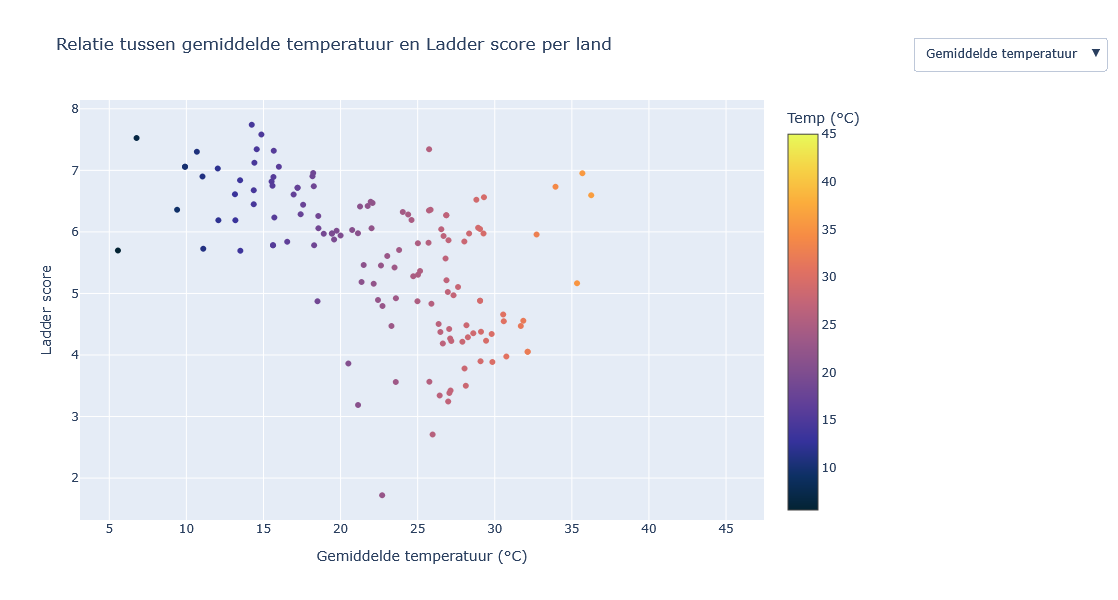

In [131]:
trace_temp = go.Scatter(
    x=df123["temperature_celsius"],
    y=df123["Ladder score"],
    mode="markers",
    marker=dict(
        color=df123["temperature_celsius"],
        colorscale="thermal",
        showscale=True,
        colorbar=dict(title="Temp (°C)")
    ),
    text=df123["country"],
    name="Gemiddelde temperatuur"
)

trace_feels_like = go.Scatter(
    x=df123["feels_like_celsius"],
    y=df123["Ladder score"],
    mode="markers",
    marker=dict(
        color=df123["feels_like_celsius"],
        colorscale="thermal",
        showscale=True,
        colorbar=dict(title="Voelt als (°C)")
    ),
    text=df123["country"],
    name="Gemiddelde gevoelstemperatuur",
    visible=False 
)

figtempsscatter = go.Figure(data=[trace_temp, trace_feels_like])
figtempsscatter.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            direction="down",
            showactive=True,
            buttons=list([
                dict(label="Gemiddelde temperatuur",
                     method="update",
                     args=[{"visible": [True, False]},
                           {"title": "Relatie tussen gemiddelde temperatuur en Ladder score per land",
                            "xaxis": {"title": "Gemiddelde temperatuur (°C)", "range" : [0,40]},
                            "yaxis": {"title": "Ladder score"}}]),

                dict(label="Gevoelstemperatuur",
                     method="update",
                     args=[{"visible": [False, True]},
                           {"title": "Relatie tussen gemiddelde gevoelstemperatuur en Ladder score per land",
                            "xaxis": {"title": "Gemiddelde gevoelstemperatuur (°C)", "range" : [0,40]},
                            "yaxis": {"title": "Ladder score"}}])
            ]),
            x=1.5,
            xanchor="right",
            y=1.15,
            yanchor="top"
        )
    ],
    width=900,
    height=600,
    title="Relatie tussen gemiddelde temperatuur en Ladder score per land",
    xaxis_title="Gemiddelde temperatuur (°C)",
    yaxis_title="Ladder score"
)

figtempsscatter.show()


> *Figuur X: Vivamus elementum semper nisi. Aenean vulputate eleifend tellus. Aenean leo ligula, porttitor eu, consequat vitae, eleifend ac, enim. Aliquam lorem ante, dapibus in, viverra quis, feugiat a, tellus.*

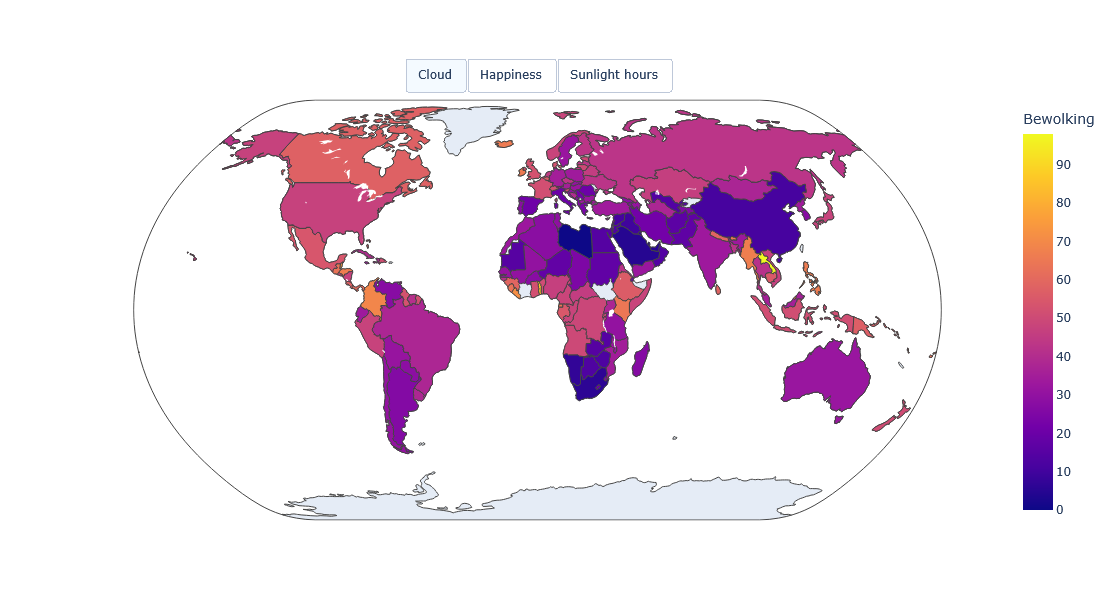

In [133]:
fighappy = px.choropleth(
    df1,
    locations='Country name',
    locationmode='country names',
    color='Ladder score',
    color_continuous_scale='Sunset',
    title='World Happiness Score by Country'
)

# Adjust size
fighappy.update_layout(width=1000, height=600)

# Adjust projection & zoom
fighappy.update_geos(projection_type='natural earth') # Figuur voor happiness score per land

sunhoursfig = px.choropleth(
    df123,
    locations='country',
    locationmode='country names',
    color='Sunlight hours',
    color_continuous_scale='Sunset',
    title='Hoeveelheid uren zon per land (gemiddeld)'
)
# Adjust size
sunhoursfig.update_layout(width=1000, height=600)

# Adjust projection & zoom
sunhoursfig.update_geos(projection_type='natural earth') # Figuur voor aantal uren zonlicht per land
# Dit is data die is genomen van de mode, dus het gemiddelde van de meest voorkomende waarden. denk ik.

cloudfig = px.choropleth(
    df123,
    locations='country',
    locationmode='country names',
    color='cloud',
    color_continuous_scale='Sunset',
    title='Hoeveelheid bewolking per land (in percentage)'
)

# Adjust size
cloudfig.update_layout(width=1000, height=600)

# Adjust projection & zoom
cloudfig.update_geos(projection_type='natural earth')   # Figuur van cloudiness in % per land

# traces maken van fig data
cloud_trace = cloudfig.data[0]
happiness_trace = fighappy.data[0]
sunhours_trace = sunhoursfig.data[0]

# Zo is de eerste zichtbaar als eerst
cloud_trace.visible = True
happiness_trace.visible = False
sunhours_trace.visible = False

# Issue met de kleur legenda ding fixen
cloud_trace.coloraxis = "coloraxis"
happiness_trace.coloraxis = "coloraxis"
sunhours_trace.coloraxis = "coloraxis"

figcombi = go.Figure(data=[cloud_trace, happiness_trace, sunhours_trace])

figcombi.update_layout(
    coloraxis = dict(colorbar=dict(title="Bewolking")),  # Het moment dat je kiest voor een andere, verdwijnt de tekst boven de color legenda...
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=0.5,
            y=1.1,
            xanchor="center",
            buttons=[
                dict(label="Cloud",
                     method="update",
                     args=[{"visible": [True, False, False]},
                           {"title": cloudfig.layout.title.text,
                            "coloraxis": dict(colorbar=dict(title="Bewolking")) # Werkt niet, maar hoe wel? iig beter dan verkeerde legenda ig
                           }]),
                dict(label="Happiness",
                     method="update",
                     args=[{"visible": [False, True, False]},
                           {"title": fighappy.layout.title.text,
                           "coloraxis": dict(colorbar=dict(title="Happiness score"))
                           }]),
                dict(label="Sunlight hours",
                     method="update",
                     args=[{"visible": [False, False, True]},
                           {"title": sunhoursfig.layout.title.text,
                            "coloraxis": dict(colorbar=dict(title="Hoeveelheid uren zonlicht"))
                           }]),
            ])])
figcombi.update_layout(width=1000, height=600)
figcombi.update_geos(projection_type='natural earth')
figcombi.show()  # Combi van de 3

> *Figuur X: Drie interactieve wereldkaarten gecombineerd tot 1 figuur. UITLEG WAT TE ZIEN IS*

In [135]:
# Data selecteren en middelen per land
df_climate = df123[['country', 'Sunlight hours', 'cloud', 'temperature_celsius', 'Ladder score']].dropna()
df_climate = df_climate.groupby('country', as_index=False).mean(numeric_only=True)

# Correlaties berekenen
corr_matrix = df_climate[['Sunlight hours', 'cloud', 'temperature_celsius', 'Ladder score']].corr()

# Waarden ophalen
corr_sun = corr_matrix.loc['Sunlight hours', 'Ladder score']
corr_cloud = corr_matrix.loc['cloud', 'Ladder score']
corr_temp = corr_matrix.loc['temperature_celsius', 'Ladder score']

# Resultaten printen
print(f"De correlatie tussen Sunlight hours en de Happiness Ladder score is {corr_sun:.2f}.")
print(f"De correlatie tussen cloud en de Happiness Ladder score is {corr_cloud:.2f}.")
print(f"De correlatie tussen temperature_celsius en de Happiness Ladder score is {corr_temp:.2f}.")



De correlatie tussen Sunlight hours en de Happiness Ladder score is 0.11.
De correlatie tussen cloud en de Happiness Ladder score is 0.14.
De correlatie tussen temperature_celsius en de Happiness Ladder score is -0.51.


Onze analyse van drie klimatologische variabelen – zonuren, bewolking en temperatuur – toont gemengde resultaten wat betreft hun samenhang met geluk. Zowel het aantal zonuren als de mate van bewolking vertonen een zwakke positieve correlatie met de geluksscore (r = 0.11 en r = 0.14 respectievelijk). Deze verbanden zijn gering en suggereren slechts een beperkte invloed van licht en bewolking op subjectief welzijn.

Opvallend daarentegen is de matige negatieve correlatie tussen temperatuur en geluk (r = –0.51). Dit betekent dat landen met een hogere gemiddelde temperatuur doorgaans lagere geluksscores rapporteren. Deze bevinding wijkt af van de intuïtieve verwachting dat warmere klimaten prettiger zijn om in te leven, en sluit aan bij eerder onderzoek dat laat zien dat extreme hitte gepaard kan gaan met gezondheidsklachten, productiviteitsverlies en psychologisch ongemak (Berry et al., 2010; Rehdanz & Maddison, 2005)


### Conclusie 1.1
De resultaten tonen aan dat niet alle klimatologische leefomstandigheden sterk samenhangen met geluk. Hoewel zonlicht en bewolking weinig invloed lijken te hebben, blijkt een hogere gemiddelde temperatuur significant negatief geassocieerd met welzijn. Dit ondersteunt het idee dat bepaalde klimaatomstandigheden, met name warmte, kunnen bijdragen aan een lager geluksniveau, mogelijk via stress, vermoeidheid of verminderde leefbaarheid.


### Argument 1.2: Extreme weersomstandigheden zorgen voor stress en gezondheidsproblemen, wat het geluksniveau verlaagt.

De Global Environments Trends dataset definieert extreme weersomstandigheden als gebeurtenissen zoals hittegolven, hevige neerslag, extreme kou, orkanen en overstromingen (Shamim, 2025). Deze weersomstandigheden hebben aantoonbare negatieve effecten op de gezondheid van mensen, wat het welzijn en dus het geluk vermindert (BRON NOG BENOEMEN). Volgens Berry, Bowen en Kjellstrom (2010) kunnen zulke extreme weersomstandigheden leiden tot directe gezondheidsproblemen, zoals hitteberoertes en ademhalingsklachten, en indirecte effecten zoals verhoogde stress, angst en sociale verstoring. 

Ook in grootschalige empirische studies, zoals die van Rehdanz en Maddison (2005), blijkt dat mensen minder gelukkig zijn in klimaten met veel extreme temperatuurvariatie en overmatige neerslag. In landen met frequente kou of hittegolven is het geluksniveau gemiddeld lager dan in gematigde gebieden.

Peng et al. (2016) vonden dat onder andere een hoge luchtvochtigheid en lage zichtbaarheid, weersomstandigheden die vaak voorkomen bij extreme regenval of smog, negatief gecorreleerd zijn met zelfgerapporteerd geluk. Ze tonen ook aan dat de impact van weer op geluk sterker wordt naarmate de omstandigheden extremer worden.

In [140]:
df123ExtremeLadder = df123[['country','Extreme_Weather_Events', 'Ladder score']].dropna()
df123ExtremeLadder = df123ExtremeLadder.groupby('country', as_index=False).mean(numeric_only=True) # Er waren duplicate values in de oorspronkelijke dataset.
correlationmatrix = df123ExtremeLadder[['Extreme_Weather_Events','Ladder score']].corr(method='pearson')
correlationwaarde = correlationmatrix.loc['Extreme_Weather_Events', 'Ladder score']
print(f"De correlatie tussen extreme weersomstandigheden en de Happiness Ladder score is {correlationwaarde:.2f}.")

De correlatie tussen extreme weersomstandigheden en de Happiness Ladder score is -0.62.


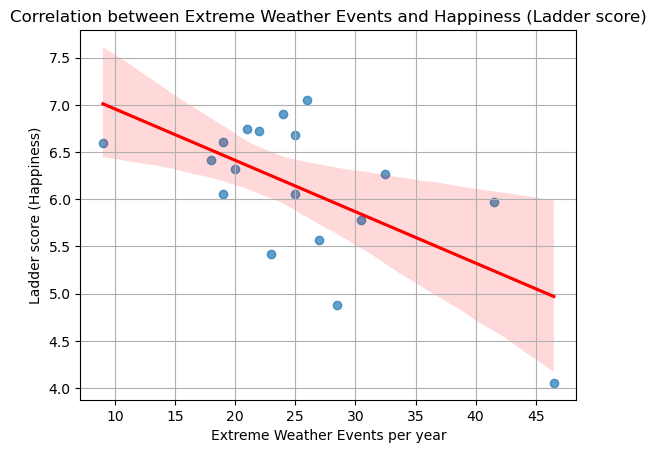

<Figure size 800x600 with 0 Axes>

In [141]:
sns.regplot(
    data=df123ExtremeLadder,
    x='Extreme_Weather_Events',
    y='Ladder score',
    scatter_kws={'alpha':0.7},
    line_kws={"color":"red"}
)
plt.title('Correlation between Extreme Weather Events and Happiness (Ladder score)')
plt.xlabel('Extreme Weather Events per year')
plt.ylabel('Ladder score (Happiness)')
plt.grid(True)
plt.figure(figsize=(8,6))
plt.show()


> *Figuur X: Vivamus elementum semper nisi. Aenean vulputate eleifend tellus. Aenean leo ligula, porttitor eu, consequat vitae, eleifend ac, enim. Aliquam lorem ante, dapibus in, viverra quis, feugiat a, tellus.*

Naast extreme weersomstandigheden zoals de bovengenoemde natuurrampen, kan luchtkwaliteit ook een rol spelen bij het geluk van mensen (Tian et al., 2022). Volgens Tian et al. (2022) vermindert het geluk van mensen als de luchtkwaliteit slechter wordt. Zo lijkt luchtvervuiling het gevoel van gelukkigheid van mensen te verminderen en juist depressieve klachten te verergeren (Zhang et al., 2017). In de World Weather Repository staan acht variabelen die te maken hebben met de luchtkwaliteit. Hieronder zijn de resultaten van de correlaties tussen de happiness ladder score en de verschillende variabelen voor luchtkwaliteit.

In [144]:
# Alle air quality variables
air_quality_vars = [
    'air_quality_Carbon_Monoxide',
    'air_quality_Ozone',
    'air_quality_Nitrogen_dioxide',
    'air_quality_Sulphur_dioxide',
    'air_quality_PM2.5',
    'air_quality_PM10',
    'air_quality_us-epa-index',
    'air_quality_gb-defra-index'
]
# Loop om elke te checken
for var in air_quality_vars:
    dfcorrAir = df123[['country', var, 'Ladder score']].dropna()
    dfcorrAir = dfcorrAir.groupby('country', as_index=False).mean(numeric_only=True)
    Aircorr_matrix = dfcorrAir[[var, 'Ladder score']].corr(method='pearson')
    Aircorr_value = Aircorr_matrix.loc[var, 'Ladder score']
    print(f"De correlatie tussen {var} en de Happiness Ladder score is {Aircorr_value:.2f}.")


De correlatie tussen air_quality_Carbon_Monoxide en de Happiness Ladder score is -0.01.
De correlatie tussen air_quality_Ozone en de Happiness Ladder score is -0.16.
De correlatie tussen air_quality_Nitrogen_dioxide en de Happiness Ladder score is 0.23.
De correlatie tussen air_quality_Sulphur_dioxide en de Happiness Ladder score is 0.04.
De correlatie tussen air_quality_PM2.5 en de Happiness Ladder score is 0.01.
De correlatie tussen air_quality_PM10 en de Happiness Ladder score is -0.00.
De correlatie tussen air_quality_us-epa-index en de Happiness Ladder score is -0.04.
De correlatie tussen air_quality_gb-defra-index en de Happiness Ladder score is -0.03.


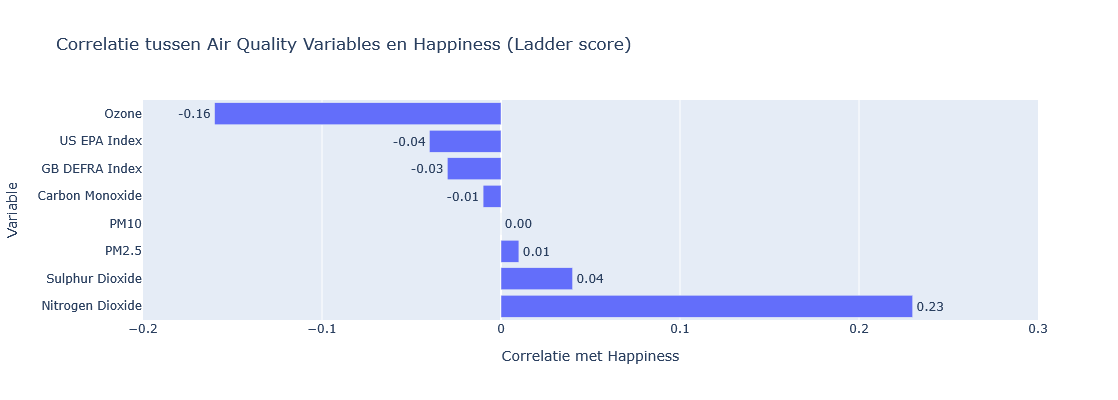

In [145]:
# Dit visualiseren, idk of het mogelijk is om dit sneller te doen dus doe ik het maar even handmatig.
data = {
    'Variable': [
        'Carbon Monoxide',
        'Ozone',
        'Nitrogen Dioxide',
        'Sulphur Dioxide',
        'PM2.5',
        'PM10',
        'US EPA Index',
        'GB DEFRA Index'
    ],
    'Correlatie met Happiness': [
        -0.01,
        -0.16,
        0.23,
        0.04,
        0.01,
        -0.00,
        -0.04,
        -0.03
    ]}

dfAirQualityHappy = pd.DataFrame(data).sort_values('Correlatie met Happiness', ascending=False)
figAirHappy = px.bar(
    dfAirQualityHappy,
    x='Correlatie met Happiness',
    y='Variable',
    orientation='h',
    title='Correlatie tussen Air Quality Variables en Happiness (Ladder score)',
    text='Correlatie met Happiness')
figAirHappy.update_traces(texttemplate='%{text:.2f}', textposition='outside')
figAirHappy.update_layout(xaxis=dict(range=[-0.2, 0.3]), width=800, height=400,showlegend=False)
figAirHappy.show()

> *Figuur X: Vivamus elementum semper nisi. Aenean vulputate eleifend tellus. Aenean leo ligula, porttitor eu, consequat vitae, eleifend ac, enim. Aliquam lorem ante, dapibus in, viverra quis, feugiat a, tellus.*

Uit de correlatieanalyse blijkt dat luchtkwaliteit weinig invloed heeft op het geluk van mensen in deze dataset. De sterkste correlatie is gevonden bij stikstofdioxide (NO₂), met een zwakke positieve correlatie van r = 0.23. Dit betekent dat landen met een hogere NO₂-concentratie iets hogere geluksscores rapporteren, al is deze samenhang zo zwak dat deze waarschijnlijk geen praktische betekenis heeft.

Daarnaast laat ozon een lichte negatieve correlatie zien met geluk (r = –0.16), wat zou kunnen wijzen op een klein negatief effect van ozonvervuiling op welzijn. Ook deze correlatie is echter te zwak om als overtuigend bewijs te gelden. Voor alle andere luchtkwaliteitsvariabelen, zoals koolmonoxide (r = –0.01), zwaveldioxide (r = 0.04), fijnstof PM2.5 (r = 0.01), fijnstof PM10 (r = –0.00) en de luchtkwaliteitsindexen (r = –0.04 en r = –0.03), is er praktisch gezien geen correlatie met geluk
.
Opvallend is dat, in tegenstelling tot luchtkwaliteit, het aantal extreme weersomstandigheden wél een sterke negatieve correlatie vertoont met geluk (r = –0.62). Dit betekent dat landen die vaker te maken hebben met natuurrampen, zoals hittegolven of overstromingen, significant lagere geluksscores rapporteren. Deze bevinding onderstreept dat de impact van klimaatverstoringen op welzijn veel sterker en directer is dan die van luchtvervuiling in deze analyse.


### Conclusie 1.2
Op basis van de resultaten kan worden geconcludeerd dat luchtkwaliteit in deze analyse nauwelijks samenhang vertoont met het geluk van mensen. Hoewel stikstofdioxide en ozon kleine correlaties laten zien, zijn deze zo zwak dat ze geen overtuigend bewijs vormen voor een direct effect van luchtvervuiling op het welzijn.
Daarentegen is de negatieve correlatie tussen het aantal extreme weersomstandigheden en geluk opvallend sterk. Dit geeft aan dat natuurrampen en klimaatextremen een veel grotere en directere impact hebben op het ervaren welzijn dan luchtvervuiling.


### Conclusie perspectief 1

Op basis van de analyse blijkt dat klimatologische omstandigheden, zoals temperatuur en extreme weersituaties, een meetbare invloed kunnen hebben op het geluksniveau van mensen in verschillende landen. Extreem weer kan leiden tot verhoogde stress, gezondheidsproblemen en economische schade, wat het algemeen welzijn negatief beïnvloedt. Toch toont de data ook aan dat er geen eenduidig verband bestaat: landen met een minder aangenaam klimaat kunnen nog steeds een hoog geluksniveau rapporteren. Dit suggereert dat klimaat weliswaar een rol speelt in het welzijn van mensen, maar dat het geen op zichzelf staande bepalende factor is. Het effect van klimaat op geluk is dus genuanceerd en mogelijk afhankelijk van hoe samenlevingen zich aanpassen aan hun omgeving.

# Perspectief 2: Sociaal-economische factoren zijn bepalender voor geluk dan klimaat

Niet alleen het klimaat heeft invloed op het geluk. Zoals te zien in Figuur X, scoren de Scandinavische landen hoge Happiness scores in vergelijking met andere landen die vaak minder extreme weersomstandigheden hebben. Andere factoren, zoals GDP per capita (BBP per hoofd) en vrijheid, hebben ook invloed op de blijheid van mensen in een bepaald land. Dit komt doordat deze factoren extra betekenis hebben: vrijheid geeft meer ruimte voor men om zichzelf te uiten en een hoger GDP per capita betekent dat individuen in een land vaak meer te besteden hebben.
Daarom wordt er gekeken naar de volgende twee argumenten. Ten eerste, dat de Scandinavische landen met extremere weersomstandigheden toch hoge Happiness scores hebben vanwege hun sterke sociale factoren. Ten tweede hebben landen met over het algemeen hogere GDP per capita en een mindere perceptie van corruptie hogere Happiness scores. Hieronder zal er meer worden gezegd over de twee argumenten.


## Argument 2.1: Landen als Zweden, Noorwegen en Finland hebben lange, koude winters, maar behoren tot de gelukkigste landen dankzij sterke sociale vangnetten, gezondheidszorg en welvaart.

Uit Figuur X kunnen we zien dat er een positieve correlatie is tussen Social support en de Happiness score in verschillende landen. Landen met een betere sociale steun, hebben ook vaker een hogere Happiness score. Hieruit valt vooral op dat de landen bovenaan de lijst voornamelijk Scandinavische landen zijn (Zweden, Noorwegen, Finland, IJsland en Denemarken). Als we dit vergelijken met landen met een milder klimaat (tussen de 16 en 23 graden), zien we dat deze landen nog steeds, ondanks redelijke hoge scores in Social support en milder klimaat, toch lager scoren dan de Scandinavische landen. Dit komt zeker niet alleen door Social support en klimaat, maar de Scandinavische landen scoren over het algemeen veel hoger op alle andere factoren in dataset 1 dan andere landen.

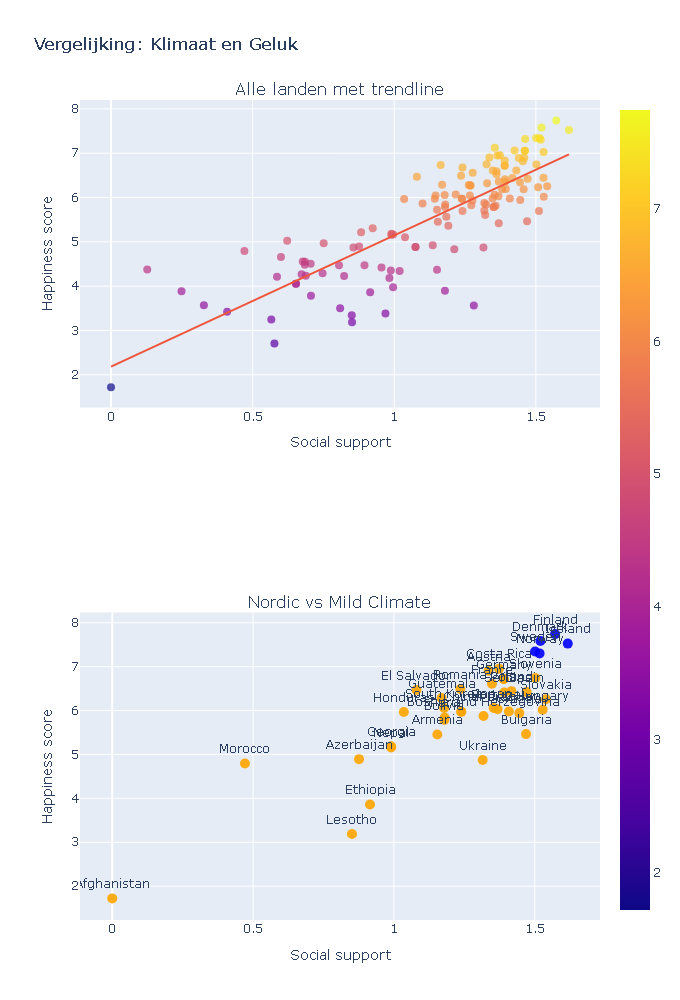

In [154]:
# Definieer Nordic en gemiddeld warme landen
nordics = ['Sweden', 'Norway', 'Finland', 'Denmark', 'Iceland']
avg_temp_df = df123[(df123['temperature_celsius'] >= 16) & (df123['temperature_celsius'] <= 23)]
avg_temp_countries = avg_temp_df['country'].unique()

# Voeg Highlight-kolom toe voor categorisering
def climate_category(row):
    if row['country'] in nordics:
        return 'Nordic'
    elif row['country'] in avg_temp_countries:
        return 'Mild Climate'
    else:
        return 'Other'

df123['Highlight'] = df123.apply(climate_category, axis=1)

# Eerste plot: alle landen, viridis kleuren op basis van Ladder score
scatter_all = px.scatter(
    df123,
    x='Social support',
    y='Ladder score',
    color='Ladder score',                  # Viridis op happiness
    color_continuous_scale='viridis',
    trendline='ols',                        
    title='Correlatie: Social Support vs Happiness (alle landen)',
    hover_name='country'
)

scatter_all.update_traces(marker=dict(size=8, opacity=0.7), textposition='top center')

# Tweede plot: enkel Nordic vs Mild Climate landen
scan_vs_mild = px.scatter(
    df123[df123['Highlight'].isin(['Nordic', 'Mild Climate'])],
    x='Social support',
    y='Ladder score',
    color='Highlight',
    color_discrete_map={'Nordic': 'blue', 'Mild Climate': 'orange'},
    text='country',
    title='Nordic vs Mild Climate landen: Social Support vs Happiness',
    hover_name='country'
)

scan_vs_mild.update_traces(marker=dict(size=10, opacity=0.9), textposition='top center')

# Combineer beide in subplots
final_fig = make_subplots(rows=2, cols=1, subplot_titles=("Alle landen met trendline", "Nordic vs Mild Climate"))

for trace in scatter_all.data:
    final_fig.add_trace(trace, row=1, col=1)
for trace in scan_vs_mild.data:
    final_fig.add_trace(trace, row=2, col=1)

# 6. Layout en labels
final_fig.update_layout(
    height=1000,
    width=1000,
    title_text="Vergelijking: Klimaat en Geluk",
    showlegend=False
)
final_fig.update_xaxes(title_text="Social support", row=1, col=1)
final_fig.update_xaxes(title_text="Social support", row=2, col=1)
final_fig.update_yaxes(title_text="Happiness score", row=1, col=1)
final_fig.update_yaxes(title_text="Happiness score", row=2, col=1)

# 7. Toon figuur
final_fig.show()

> *Figuur X, hierop is te zien dat landen met meer Social support, ook blijer zijn over het algemeen. Daarnaast is te zien dat het temperatuur verschil hier ook niet uitmaakt en landen met betere sociale steun toch hoger scoren.*

## Argument 2.2: Economische stabiliteit, werkgelegenheid, gezondheidszorg en sociale verbondenheid dragen meer bij aan geluk dan klimaatfactoren.

Landen met een hoge Log GDP per capita bevinden zich rechts in de grafiek en tonen vrijwel zonder uitzondering hoge happiness scores. Dit suggereert dat economische stabiliteit, waaronder dus factoren als werkgelegenheid, inkomenszekerheid en toegang tot voorzieningen, bijdraagt aan een verhoogd gevoel van welzijn. In rijkere landen is de kans op langdurige werkloosheid kleiner, zijn er meer middelen voor sociale zekerheid, en is de publieke infrastructuur (zoals transport en huisvesting) doorgaans beter geregeld.

Economische rijkdom vertaalt zich ook in betere gezondheidsvoorzieningen. In landen met een hoger BBP per capita is de Healthy life expectancy doorgaans aanzienlijk hoger, wat op zijn beurt bijdraagt aan het algemene levensgeluk. Gezond zijn is niet alleen een fysieke toestand maar beïnvloedt ook mentale gezondheid, levenskwaliteit en de mate waarin mensen actief kunnen deelnemen aan de samenleving.

De grootte van de bubbels weerspiegelt het niveau van social support, en duidelijk is dat grotere bubbels (meer steun) vaker in het bovenste deel van de grafiek verschijnen, bij landen met hogere geluksscores. Dit impliceert dat zelfs als economische omstandigheden goed zijn, sociale verbondenheid een essentiële factor blijft. Mensen voelen zich gelukkiger als ze op vrienden, familie of de overheid kunnen terugvallen in moeilijke tijden.

Hoewel klimaat in deze visualisatie niet direct is opgenomen, laat het ontbreken ervan zien dat een hoge happiness score ook mogelijk is zonder zonnig, mild weer. Landen met strenge winters, zoals Zweden, Noorwegen en Finland, scoren hoog op zowel GDP als social support, en behoren tegelijk tot de gelukkigste landen ter wereld. Dit ondersteunt het idee dat sociaal-economische factoren zwaarder wegen dan klimaatfactoren in het verklaren van geluk.

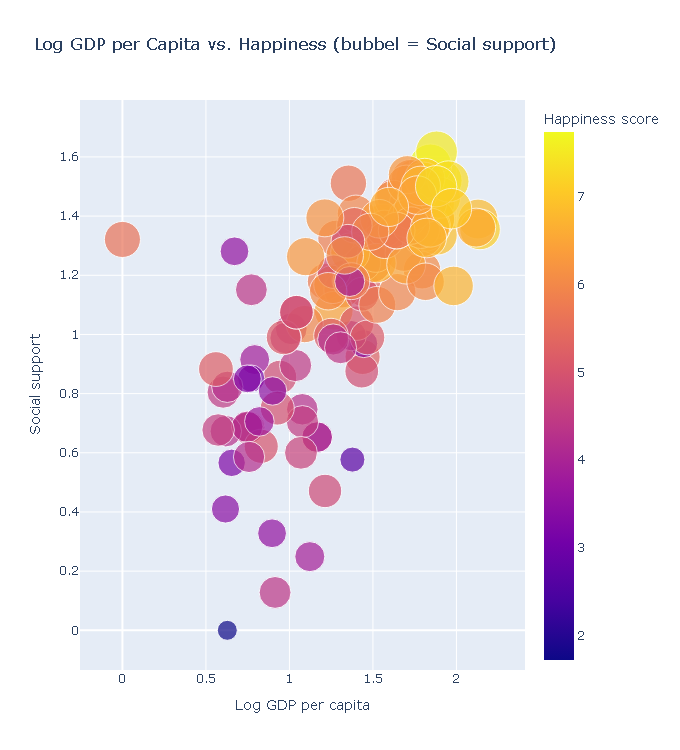

In [158]:
# Verwijder alle rijen waar één van deze kolommen NaN is
df_clean = df123.dropna(subset=['Log GDP per capita', 'Ladder score', 'Social support'])

# Maak de bubble plot op de schone data
figbub = px.scatter(
    df_clean,
    x='Log GDP per capita',
    y='Social support',
    size='Ladder score',
    color='Ladder score',
    hover_name='country',
    size_max=30,
    height=750,
    title='Log GDP per Capita vs. Happiness (bubbel = Social support)',
    labels={
        'Log GDP per capita': 'Log GDP per capita',
        'Ladder score': 'Happiness score',
        'Social support': 'Social support'
    }
)

figbub.show()  # Waarom heeft Venezuela 0 gdp LMAO

> *Figuur X: Vivamus elementum semper nisi. Aenean vulputate eleifend tellus. Aenean leo ligula, porttitor eu, consequat vitae, eleifend ac, enim. Aliquam lorem ante, dapibus in, viverra quis, feugiat a, tellus.*

### Conclusie perspectief 2

Hiero schrijven

# Conclusie

## Reflection

Een aantal zaken was ons opgevallen tijdens het project.
- De Global Environments Dataset had minder data dan de andere datasets; uiteindelijk waren er maar zeventien rows die toepasbaar waren voor ons onderzoek. Aangezien er minder landen in deze dataset waren verwerkt, zijn de correlaties en conclusies die we met deze dataset hebben getrokken, mogelijk toch niet betrouwbaar genoeg. We konden verder geen andere bruikbare dataset vinden met de gegevens die we zochten. Ook was de variabele `Extreme_Weather_Events` niet duidelijk gedefinieerd in de omschrijving van de dataset. Daarom is er een mail verzonden naar de eigenaar van de dataset, om de definitie van de variabele te verhelderen. Gelukkig kregen we al gauw een antwoord en was de variabele nog wel bruikbaar voor ons onderzoek
- Tijdens het presenteren van onze draft werd er erg weinig feedback gegeven. De enige feedback die werd gegeven, ging over de hoeveelheid visualisaties. Hierdoor is er besloten om veel visualisaties te combineren tot een visualisatie, met een knop waardoor er van afbeelding gewisseld kan worden.

Verder is iedere keuze voor het project goed besproken met de groepsleden onderling en verliep de samenwerking erg vlot.

## Work Distribution
Bij dit onderzoek heeft ieder lid ongeveer evenveel werk verricht. Ook was iedereen betrokken bij het uitzoeken van passende datasets. Wel heeft ieder lid zich iets meer op bepaalde delen van het project gericht. Zo heeft Mieke alle GitHub troubleshooting verricht en de website in orde gemaakt. Aryan is veel bezig geweest met perspectief 2 en Lucas, Mieke en Reyna meer met perspectief 1. Reyna heeft de dataset preprocessing gedaan en geholpen met het grootste deel van de visualisaties en structuur van de notebook. Lucas heeft zich gefocust op het aantonen van correlaties en de conclusies en uitwerkingen van de data. Iedereen heeft elkaar geholpen als er ergens iets vastliep; zo heeft ieder lid de anderen aangevuld.

## References (opmaak mogelijk anders)

- Helliwell, J. F., Layard, R., & Sachs, J. D. (2017, March 20). World Happiness Report 2017. The World Happiness Report. https://worldhappiness.report/ed/2017/    
- Helliwell, J. F., Layard, R., Sachs, J. D., De Neve, J.-E., Aknin, L. B., & Wang, S. (Eds.). (2024). World Happiness Report 2024. University of Oxford: Wellbeing Research Centre.       
- Nidula Elgiriyewithana. (2025). World Weather Repository ( Daily Updating ) [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/12171408    
- Peng, Y., Tang, J., Fu, Y., Fan, I., Hor, M., & Chan, T. (2016). Analyzing Personal Happiness from Global Survey and Weather Data: A Geospatial Approach. PLoS ONE, 11(4), e0153638. https://doi.org/10.1371/journal.pone.0153638   
- Rehdanz, K., & Maddison, D. (2004). Climate and happiness. Ecological Economics, 52(1), 111–125. https://doi.org/10.1016/j.ecolecon.2004.06.015      
- Shamim, A. (2025, April 24). Global Environmental Trends 2000-2024. https://www.kaggle.com/datasets/adilshamim8/temperature
- Tian X, Zhang C, Xu B. The Impact of Air Pollution on Residents' Happiness: A Study on the Moderating Effect Based on Pollution Sensitivity. Int J Environ Res Public Health. 2022 Jun 20;19(12):7536. doi: 10.3390/ijerph19127536. PMID: 35742783; PMCID: PMC9224219.
- Tsutsui, Y., 2013: Weather and Individual Happiness. Wea. Climate Soc., 5, 70–82, https://doi.org/10.1175/WCAS-D-11-00052.1.
- World Happiness Report - Sustainable Development Solutions Network. (2025, March 20). https://www.unsdsn.org/our-work/world-happiness-report/
- Zhang, X., Zhang, X., & Chen, X. (2017). Happiness in the air: How does a dirty sky affect mental health and subjective well-being? Journal of Environmental Economics and Management, 85, 81–94. https://doi.org/10.1016/j.jeem.2017.04.001 
     

   
     
    

## Appendix

Generatieve AI (ChatGPT met GPT-4o) is gebruikt als hulpmiddel bij dit document, zoals te zien is in onderstaande tabel

| Reden voor gebruik | Onderdeel | Gebruikte prompt |
| ------------------------ | --------------------------------- | -------------------------------------------- |
| Errors oplossen in de code | Dataset preprocessing | "I get this error in a notebook: A value is trying to be set on a copy of a slice from a DataFrame" |
| Omzetten van waardes voor berekening | Dataset preprocessing | "How to change a column in python jupyter notebook that has  a time like ...:.. AM to hours/seconds/minutes etc?" |

> *Figuur x: Gebruik van generatieve AI dat heeft bijgedragen aan dit document.*